In [1]:
import model
import utils

import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

data = utils.data.Datasets("/Users/henrywilliams/Documents/uni/amml/assessment/data")


def gradient(X, Y):
    return X - Y


BATCH_SIZE = 1
EPOCHS = 10

device = "mps"
test = data.n6_full(image_shape=(1, 36, 36))
train = data.n6_train(image_shape=(1, 36, 36))
train_loader = DataLoader(train, shuffle=True, batch_size=BATCH_SIZE)

In [ ]:
rim = model.RIM(
    1,
    32,
    (5, 3, 3),
    1,
    13,
    gradient,
).to(device)

criterion = nn.MSELoss()
learning_rate = 0.0002
optimizer = torch.optim.Adam(rim.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

train_images = np.zeros((EPOCHS, 36, 36, 1))
for epoch in range(EPOCHS):
    train_loop = tqdm(
        enumerate(train_loader),
        leave=False,
        desc=f"Training {epoch + 1}/{EPOCHS}",
        total=400 // BATCH_SIZE,
        unit="batch",
        postfix=(
            f"Avg train loss: {np.mean(train_losses[:-len(train_loader)]):.2f}"
            if epoch >= 2
            else ""
        ),
    )
    torch.mps.empty_cache()
    test_loss = 0.0
    for i, seq in train_loop:
        seq = seq.to(torch.float32).to(device)
        y = Variable(seq[:, 0])
        X = Variable(torch.zeros_like(seq[:, 0]))

        optimizer.zero_grad()

        outputs = rim(X, y)

        loss = criterion(outputs, seq)

        loss = loss.to(device)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.cpu().detach().item())

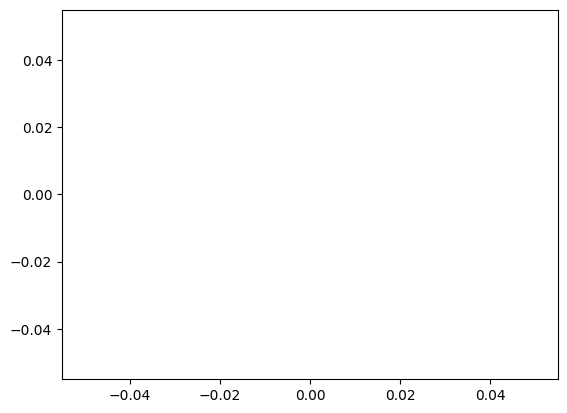

In [3]:
plt.plot(np.log(test_losses))

torch.Size([16, 36, 36, 1])

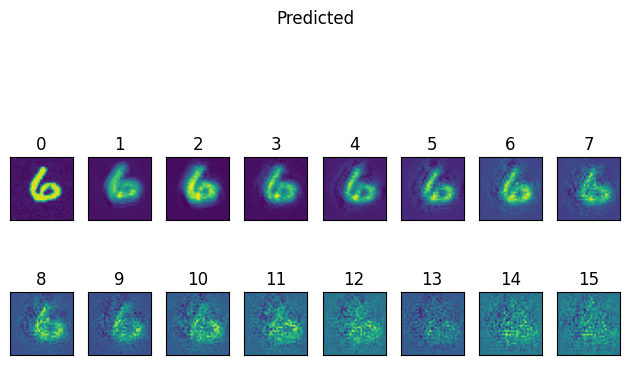

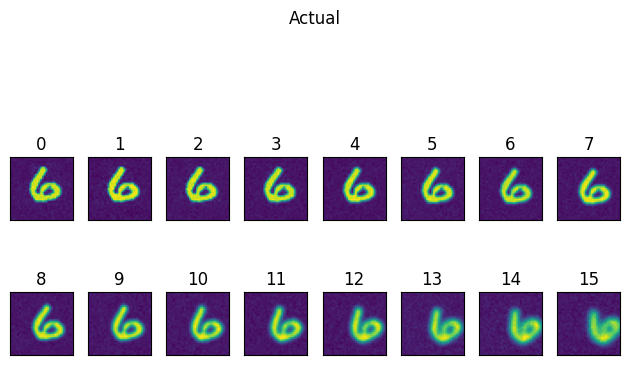

In [4]:
idx = np.random.randint(0, 400)
seq = torch.tensor(test[idx]).to(torch.float32).to(device).reshape(16, 1, 1, 36, 36)
X = seq[0]
y = seq[-1]
rim.sequence_size = 15
rim.eval()
outputs = rim(X, X).cpu().detach().reshape(-1, 16, 36, 36, 1).squeeze(0)
# outputs = rim(X, X).cpu().detach()
print(outputs.shape)
seq = seq.cpu().reshape(16, 36, 36, 1)


fig, axs = plt.subplots(2, 8)
fig.suptitle("Predicted")
fig.set_tight_layout(True)

for i, (ax, y_hat_i) in enumerate(zip(axs.flatten(), outputs)):
    ax.title.set_text(f"{i}")
    ax.imshow(y_hat_i.cpu().detach())
    ax.set_xticks([])
    ax.set_yticks([])

fig, axs = plt.subplots(2, 8)
fig.suptitle("Actual")
fig.set_tight_layout(True)

for i, (ax, y_i) in enumerate(zip(axs.flatten(), seq)):
    ax.imshow(y_i.cpu().detach())
    ax.title.set_text(f"{i}")
    ax.set_xticks([])
    ax.set_yticks([])

In [5]:
torch.save(rim.state_dict(), f"./rim-{epoch}-epochs.pt")

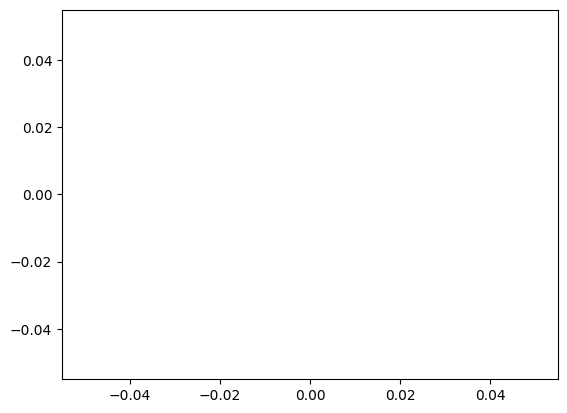

In [6]:
plt.plot(np.log(test_losses))

NameError: name 'full_seq' is not defined

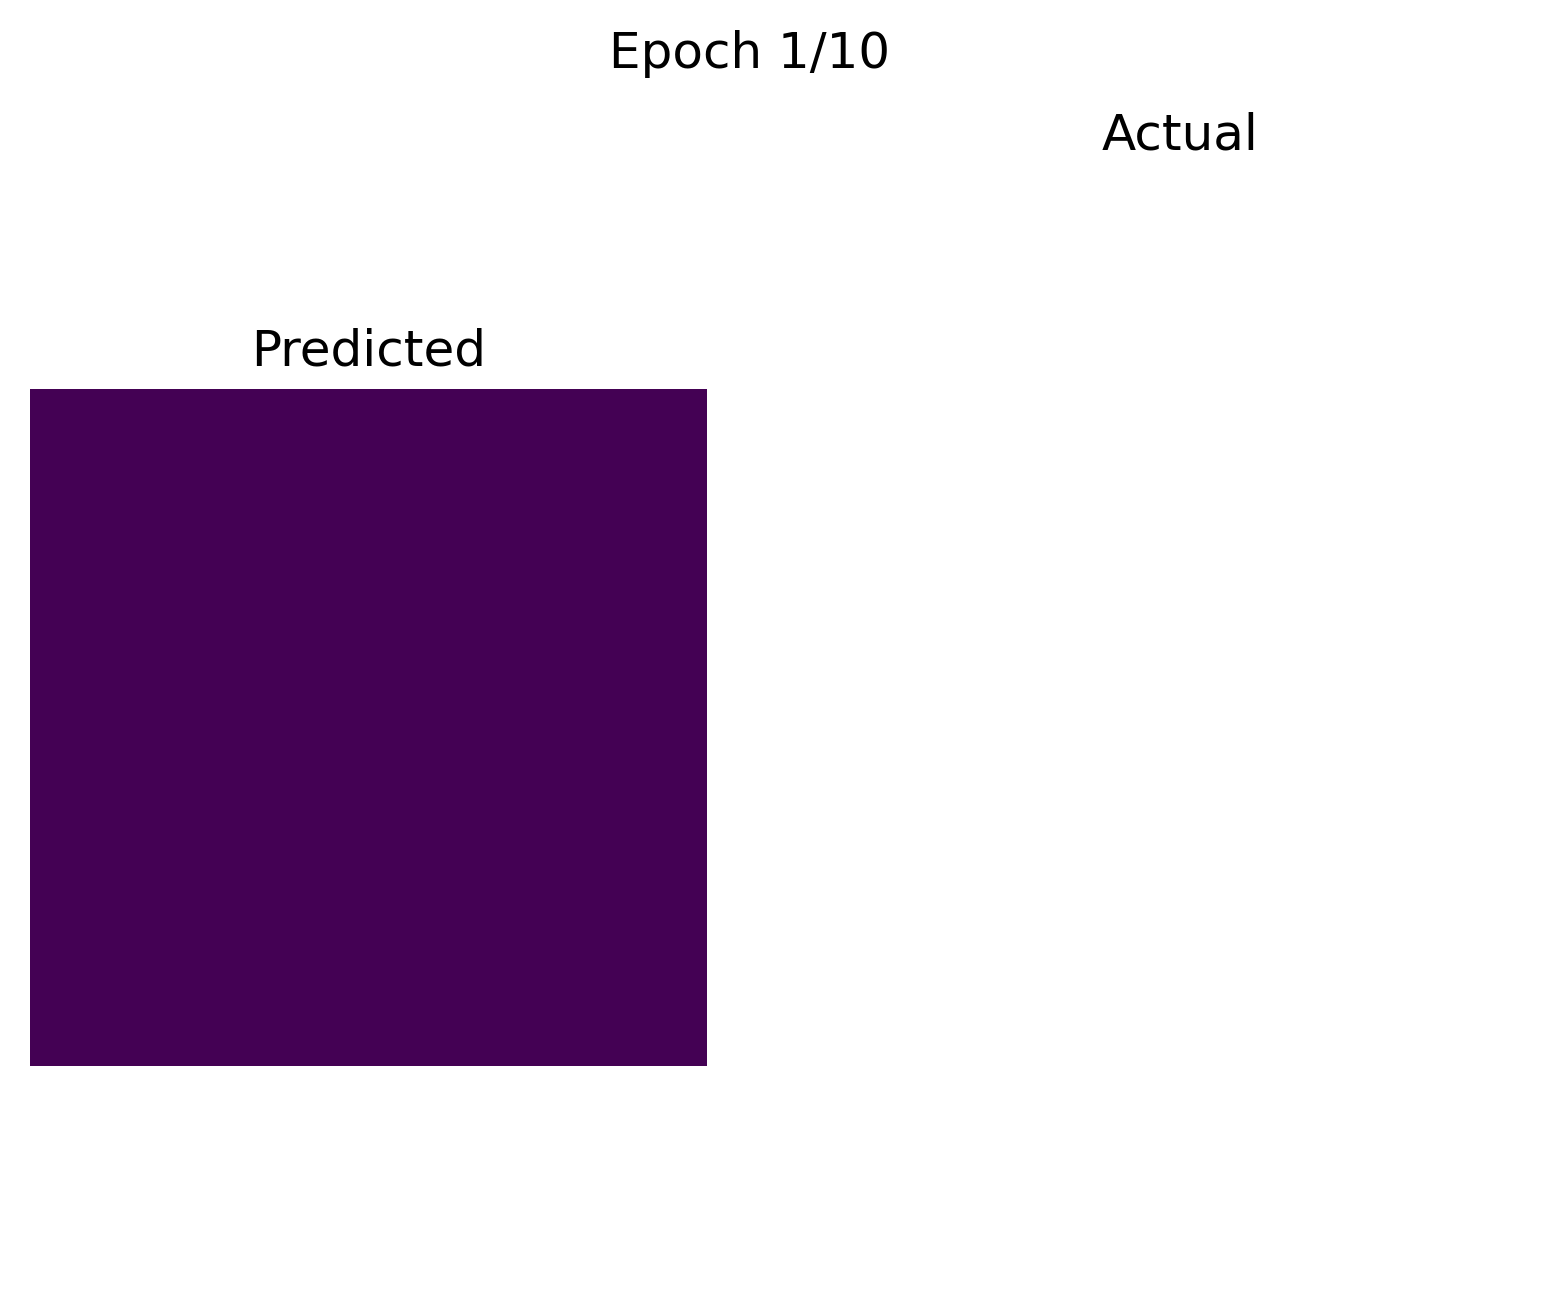

In [7]:
FPS = 24

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter("train.mp4", fourcc, FPS, (500, 500))

for idx, frame in enumerate(train_images):
    fig, axs = plt.subplots(1, 2, dpi=300)
    fig.suptitle(f"Epoch {idx + 1}/{EPOCHS}")
    axs[0].title.set_text("Predicted")
    axs[0].axis("off")
    axs[1].title.set_text("Actual")
    axs[1].axis("off")

    axs[0].imshow(frame)
    axs[1].imshow(full_seq[200, 4])

    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    frame_resized = cv2.resize(frame, (500, 500))
    writer.write(cv2.cvtColor(frame_resized, cv2.COLOR_RGB2BGR))
    plt.close(fig)
writer.release()